# MODIS BRDF/albedo algorithm

In [104]:
import pylab as plt
import numpy as np
%matplotlib inline
from glob import glob
import pandas as pd
import netCDF4
from netCDF4 import Dataset
import urllib2
from HTMLParser import HTMLParser
import os
import pickle
import kernels
import datetime
from datetime import date,timedelta
import scipy.sparse
from scipy.sparse.linalg import spsolve
from scipy.linalg import solve

def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(d):
        os.makedirs(d)
        
def save_obj(obj, name ):
    ensure_dir('obj/')
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
    


In [105]:
# load the small matrices

datakeys = np.array(['bbdr.flags', 'bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow', 'D1', 'D365'])

Ab = {}
for k in datakeys:
    k = k.strip('/')
    try:
        Ab[k] = load_obj('Ab_store_obs_%s'%k)
    except:
        pass
print Ab.keys()

['mod09', 'myd09', 'bbdr.vgt', 'bbdr.meris']


In [106]:
# load the full matrices 
datakeys = np.array(['bbdr.flags', 'bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow', 'D1', 'D365'])

Abb = {}
for k in datakeys:
    k = k.strip('/')
    try:
        Abb[k] = load_obj('Ab_store_%s'%k)
    except:
        pass
print Abb.keys()

['D365', 'myd09', 'bbdr.vgt', 'prior.v2.snow', 'mod09', 'prior.v2.nosnow', 'bbdr.meris', 'D1']


In [107]:
xp = spsolve(Abb['prior.v2.nosnow']['A'], Abb['prior.v2.nosnow']['b'])

In [108]:
nelemen = Ab['mod09']['A'].shape[-1]
print nelemen
print Ab['bbdr.%s'%'vgt'].keys()

# work out full days extent
d0,d1 = Ab['bbdr.%s'%'vgt']['doys'][0],Ab['mod09']['doys'][-1]
print d0,d1
ndays = (d1-d0) + 1
print ndays
bands = np.array(['VIS','NIR','SW'])
nbands = len(bands)

9
['A', 'b', 'doys']
20 6482
6463


In [ ]:

xs = []
ds = []

for d in xrange(0,ndays,8):
    bp = False
    A = 0.
    b = 0.
    count = 0
    if d == 1240:
        bp = True
    for dd in xrange(0,16):
        ddd = dd + d
        # find d + dd in c
#        for sensor in ['mod09', 'myd09', 'bbdr.meris', 'bbdr.vgt']:
#        for sensor in ['mod09']:
        for sensor in ['bbdr.meris', 'bbdr.vgt']:

            ww = np.where(np.array(Ab[sensor]['doys']) == ddd)[0]
            for w in ww:
                avalue = Ab[sensor]['A'][w]
                if np.isfinite(avalue).all():
                    count += 1
                    bvalue = Ab[sensor]['b'][w]
                    A += avalue
                    b += bvalue
                    if bp:
                    #import pdb;pdb.set_trace()

    if count > 7:
        try:
            x = solve(A,b)
            xs.append(x)
            ds.append(d)
            bok = b.copy()
            aok = A.copy()
        except:
            #print 'bum A',A
            print d,'bum b',b
            print A[0,0]
            print A[:3,:3]/A[0,0]
            print b[:3]/A[0,0]

> <ipython-input-149-a57986fbc966>(11)<module>()
-> for dd in xrange(0,16):
(Pdb) n
> <ipython-input-149-a57986fbc966>(12)<module>()
-> ddd = dd + d
(Pdb) 
> <ipython-input-149-a57986fbc966>(16)<module>()
-> for sensor in ['bbdr.meris', 'bbdr.vgt']:
(Pdb) 
> <ipython-input-149-a57986fbc966>(18)<module>()
-> ww = np.where(np.array(Ab[sensor]['doys']) == ddd)[0]
(Pdb) 
> <ipython-input-149-a57986fbc966>(19)<module>()
-> for w in ww:
(Pdb) 
> <ipython-input-149-a57986fbc966>(16)<module>()
-> for sensor in ['bbdr.meris', 'bbdr.vgt']:
(Pdb) n
> <ipython-input-149-a57986fbc966>(18)<module>()
-> ww = np.where(np.array(Ab[sensor]['doys']) == ddd)[0]
(Pdb) 
> <ipython-input-149-a57986fbc966>(19)<module>()
-> for w in ww:
(Pdb) 
> <ipython-input-149-a57986fbc966>(20)<module>()
-> avalue = Ab[sensor]['A'][w]
(Pdb) 
> <ipython-input-149-a57986fbc966>(21)<module>()
-> if np.isfinite(avalue).all():
(Pdb) 
> <ipython-input-149-a57986fbc966>(22)<module>()
-> count += 1
(Pdb) 
> <ipython-input-149-a579

In [72]:
print x

[  3.12520447e+36  -5.49703558e-02  -2.58515315e-01   1.01065971e+36
   3.07311712e-01  -4.75780823e+00   2.15577980e+36   8.48600998e+00
  -2.02490202e+01]


(509, 9) (509,)


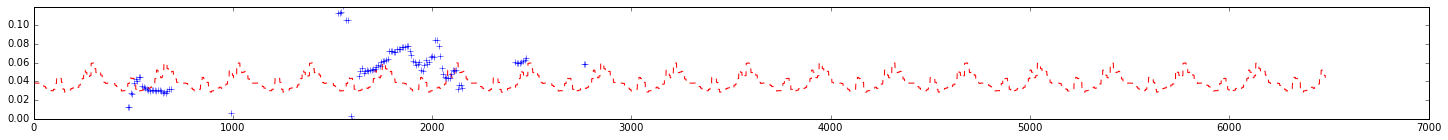

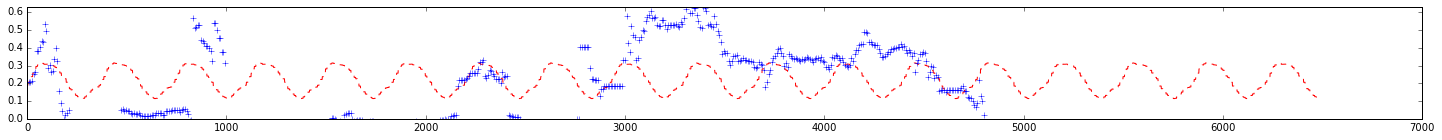

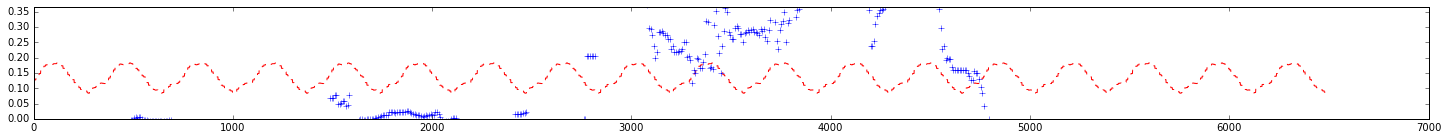

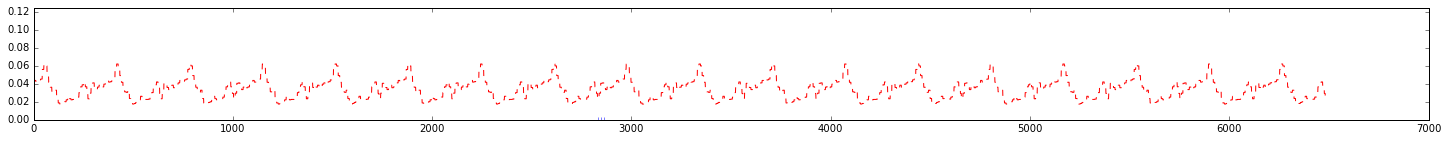

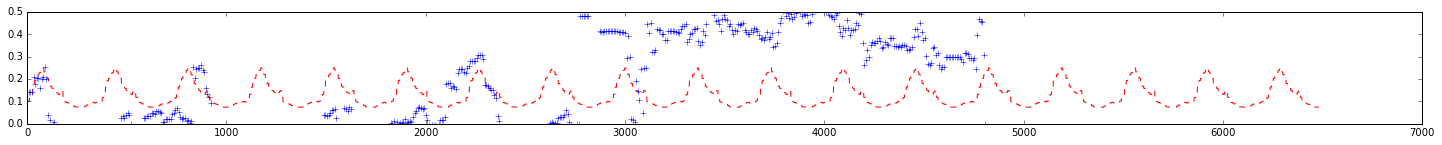

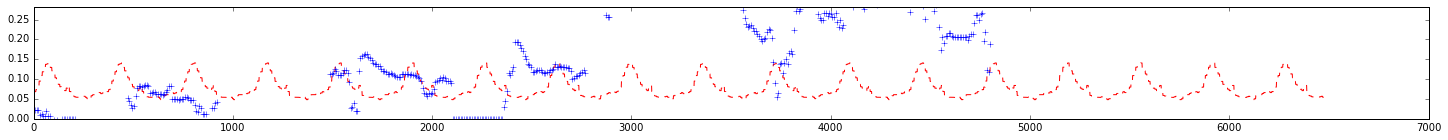

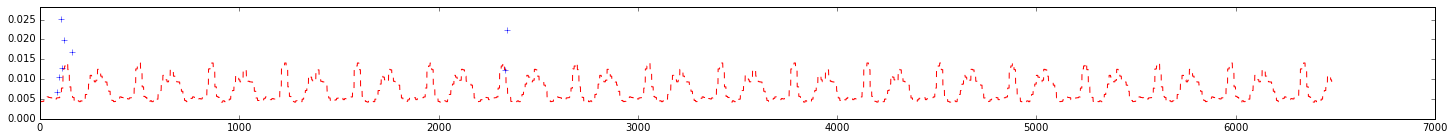

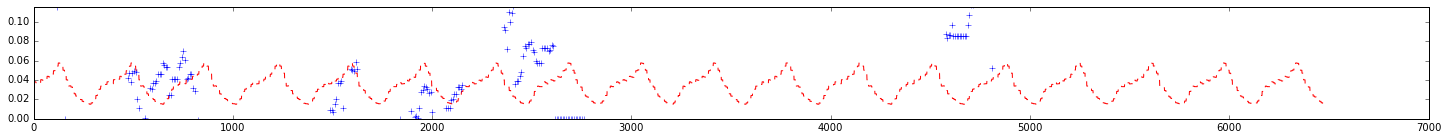

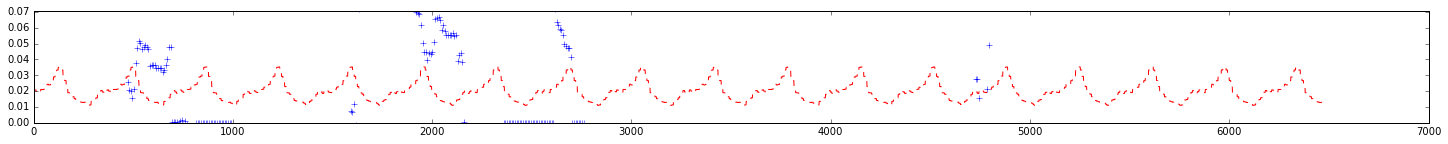

In [128]:
xs = np.array(xs)
ds = np.array(ds)
print xs.shape,ds.shape
for i in xrange(xs.shape[1]):
    plt.figure(figsize=(25,2))
    plt.plot(xp[i::nelemen],'r--')
    plt.plot(ds,xs[:,i],'+')
    plt.ylim(0,np.max(xp[i::nelemen])*2)

In [134]:
np.matrix(aok).I * np.matrix(bok).T

matrix([[ -9.44473297e+21],
        [  1.00000000e+00],
        [  5.71428571e-01],
        [  3.98768399e+36],
        [  4.44089210e-16],
        [  6.00000000e-01],
        [  6.03399551e+36],
        [  5.26315789e-02],
        [ -6.31578947e-01]])

In [136]:
bok

array([  5.98152598e+37,   1.98770295e+74,   3.97540590e+74,
         6.97844698e+37,   2.98155442e+74,   4.96925737e+74,
         4.98460498e+37,   1.98770295e+74,  -5.72119307e+36])

In [138]:
np.matrix(aok[:3,:3]).I * np.matrix(bok[:3]).T

matrix([[ -9.44473297e+21],
        [  1.00000000e+00],
        [  5.71428571e-01]])

In [139]:
aok

array([[  1.00000000e+01,   1.99384199e+37,   6.97844698e+37,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.99384199e+37,   1.98770295e+74,  -1.96595802e+37,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  6.97844698e+37,  -1.96595802e+37,   6.95696032e+74,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+01,   2.99076299e+37,   4.98460498e+37,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.99076299e+37,   2.98155442e+74,   2.98155442e+74,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
   